In [1]:
# Block 1: Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
# Block 2: Load Dataset
dataset_path = "D:/ML-PROJECTS/Forgery2/train"
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

# List image files
image_files = [f for f in Path(image_dir).glob("*.jpg")]

print(f"Total Images: {len(image_files)}")


Total Images: 2328


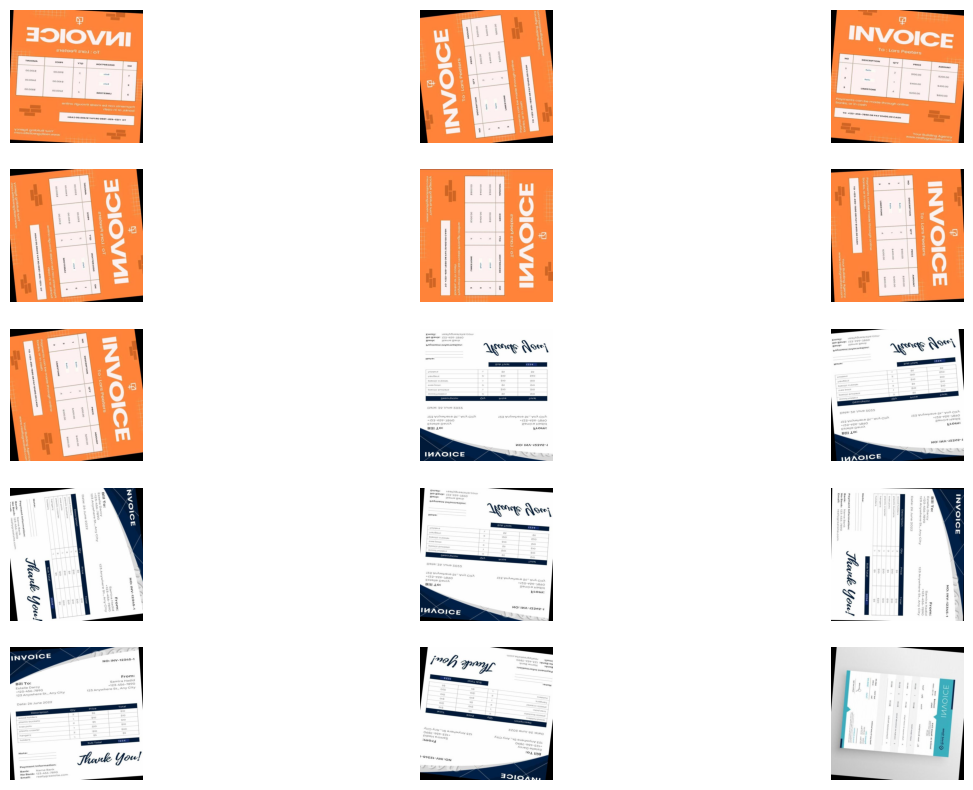

In [12]:
# Block 3: Display Sample Images
def show_images(images, rows=5, cols=3):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
    for i, img in enumerate(images[:rows * cols]):
        img_data = cv2.imread(str(img))
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        ax[i // cols, i % cols].imshow(img_data)
        ax[i // cols, i % cols].axis("off")
    plt.show()

show_images(image_files)


In [13]:
# Block 4: Resize Images
output_dir = "D:/ML-PROJECTS/Forgery2/preprocessed/resized_images"
os.makedirs(output_dir, exist_ok=True)
resize_dim = (640, 640)  # YOLOv8 prefers square images

for img_file in tqdm(image_files, desc="Resizing Images"):
    img = cv2.imread(str(img_file))
    resized_img = cv2.resize(img, resize_dim)
    cv2.imwrite(os.path.join(output_dir, img_file.name), resized_img)


Resizing Images: 100%|██████████| 2328/2328 [01:42<00:00, 22.80it/s]


In [14]:
# Block 5: Normalize Images
normalized_dir = "D:/ML-PROJECTS/Forgery2/preprocessed/normalized_images"
os.makedirs(normalized_dir, exist_ok=True)

for img_file in tqdm(Path(output_dir).glob("*.jpg"), desc="Normalizing Images"):
    img = cv2.imread(str(img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to range [0, 1]
    img = (img * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(normalized_dir, img_file.name), img)


Normalizing Images: 2328it [03:37, 10.70it/s]


In [15]:
# Block 6: Data Augmentation
augmented_dir = "preprocessed/augmented_images"
os.makedirs(augmented_dir, exist_ok=True)

transform = A.Compose([
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.5),
    A.GaussNoise(p=0.2),
    A.HorizontalFlip(p=0.5),
    ToTensorV2()
])

for img_file in tqdm(Path(normalized_dir).glob("*.jpg"), desc="Applying Augmentations"):
    img = cv2.imread(str(img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = transform(image=img)["image"]
    augmented = augmented.numpy().transpose(1, 2, 0)
    cv2.imwrite(os.path.join(augmented_dir, img_file.name), augmented)


Applying Augmentations: 2328it [03:12, 12.12it/s]


In [16]:
# Block 7: Convert Labels to YOLOv8 Format
for label_file in tqdm(Path(label_dir).glob("*.txt"), desc="Processing Labels"):
    with open(label_file, 'r') as file:
        lines = file.readlines()
    # Placeholder for potential label transformations
    with open(label_file, 'w') as file:
        file.writelines(lines)


Processing Labels: 2328it [01:11, 32.75it/s]


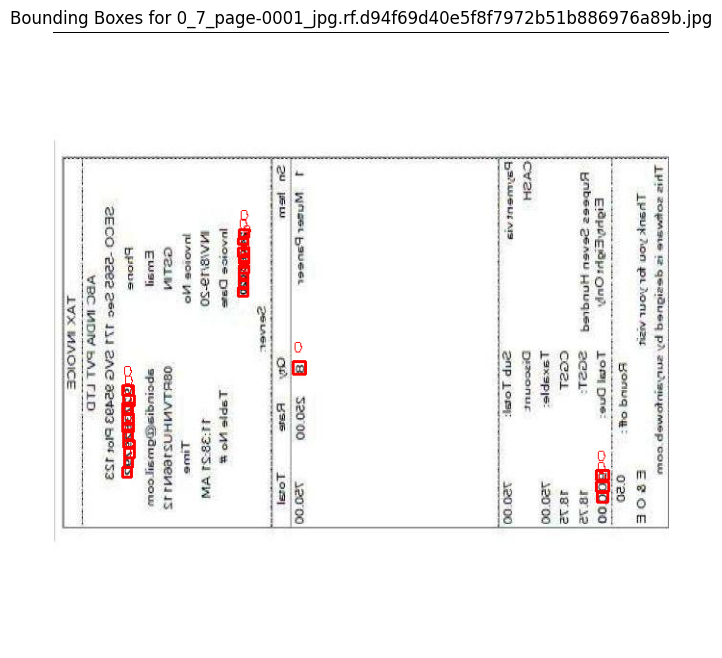

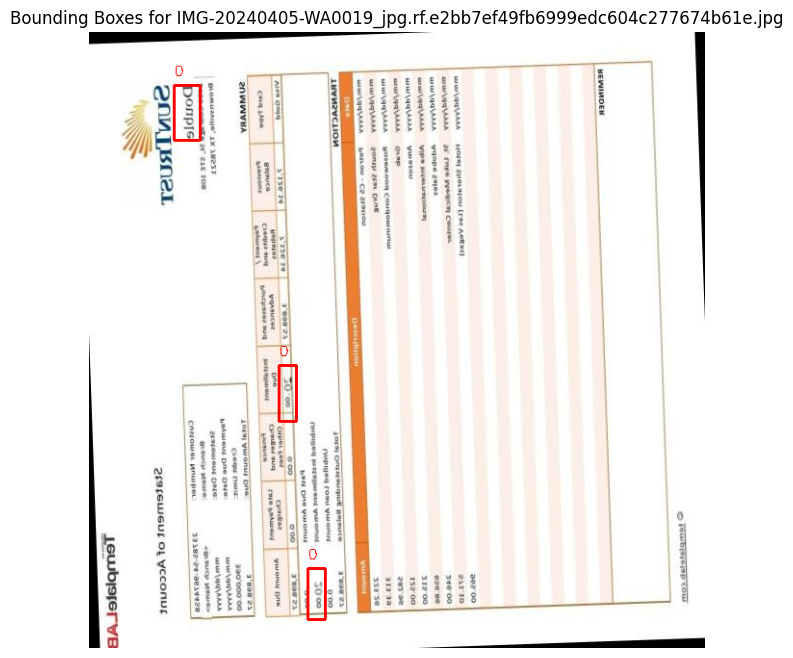

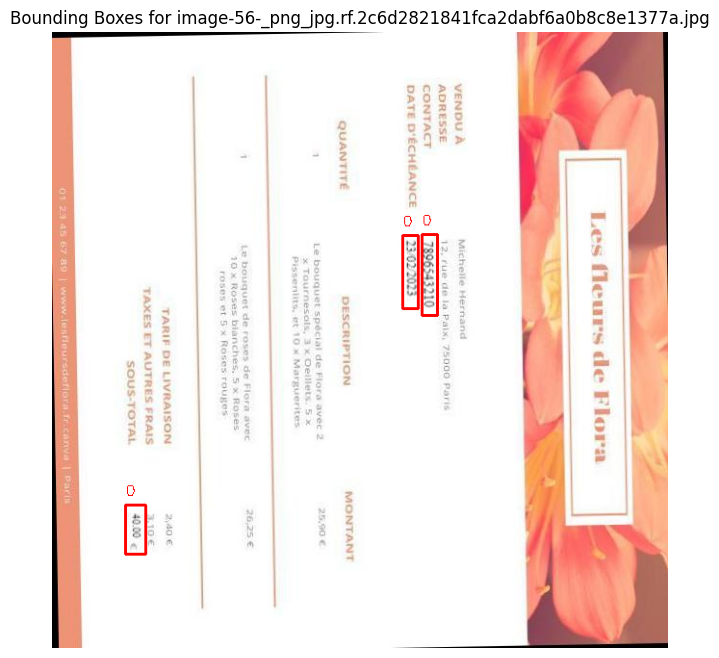

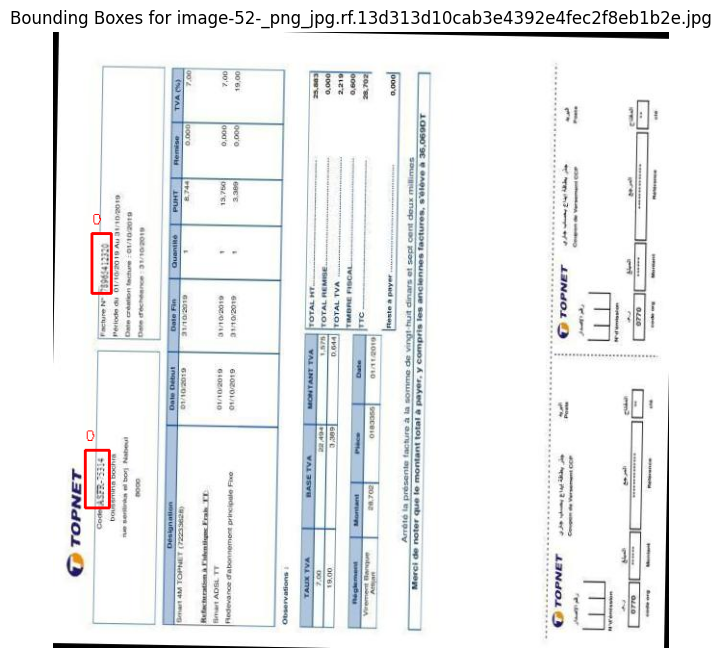

In [19]:
# Block 8: Visualize Bounding Boxes for Specific Images
def plot_bboxes_for_images(image_files, label_dir):
    """
    Plots bounding boxes for a list of images.
    
    Parameters:
        image_files (list): List of image file paths or image names.
        label_dir (str): Path to the directory containing label files.
    """
    for image_file in image_files:
        img_path = Path(image_file)
        label_file = Path(label_dir) / f"{img_path.stem}.txt"

        if img_path.exists() and label_file.exists():
            # Read and process the image
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            # Read label file and plot bounding boxes
            with open(label_file, 'r') as file:
                for line in file.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    x1, y1 = int((x_center - width / 2) * w), int((y_center - height / 2) * h)
                    x2, y2 = int((x_center + width / 2) * w), int((y_center + height / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            # Plot the image with bounding boxes
            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Bounding Boxes for {img_path.name}")
            plt.show()
        else:
            print(f"Image or label file missing for: {img_path.name}")

# Example Usage
# Define the specific image names (with their full paths or relative paths)
image_names = [
    "D:/ML-PROJECTS/Forgery2/train/images/0_7_page-0001_jpg.rf.d94f69d40e5f8f7972b51b886976a89b.jpg",
    "D:/ML-PROJECTS/Forgery2/train/images/IMG-20240405-WA0019_jpg.rf.e2bb7ef49fb6999edc604c277674b61e.jpg",
    "D:/ML-PROJECTS/Forgery2/train/images/image-56-_png_jpg.rf.2c6d2821841fca2dabf6a0b8c8e1377a.jpg",
    "D:/ML-PROJECTS/Forgery2/train/images/image-52-_png_jpg.rf.13d313d10cab3e4392e4fec2f8eb1b2e.jpg"
]

# Define the path to the labels directory
labels_directory = "D:/ML-PROJECTS/Forgery2/train/labels/"

# Call the function
plot_bboxes_for_images(image_names, labels_directory)


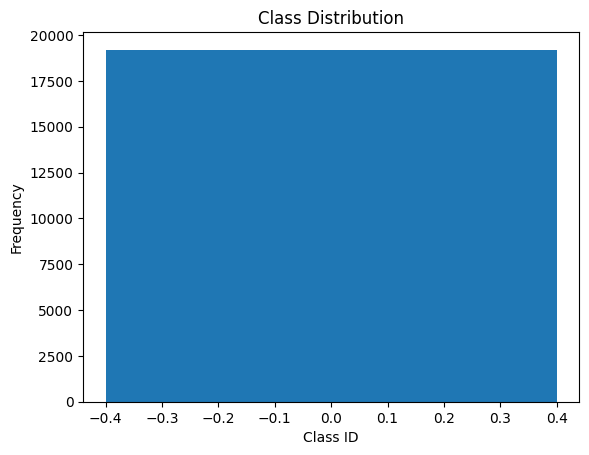

In [20]:
# Block 9: Check Data Distribution
label_counts = {}
for label_file in Path(label_dir).glob("*.txt"):
    with open(label_file, 'r') as file:
        for line in file.readlines():
            class_id = int(line.strip().split()[0])
            label_counts[class_id] = label_counts.get(class_id, 0) + 1

plt.bar(label_counts.keys(), label_counts.values())
plt.title("Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.show()


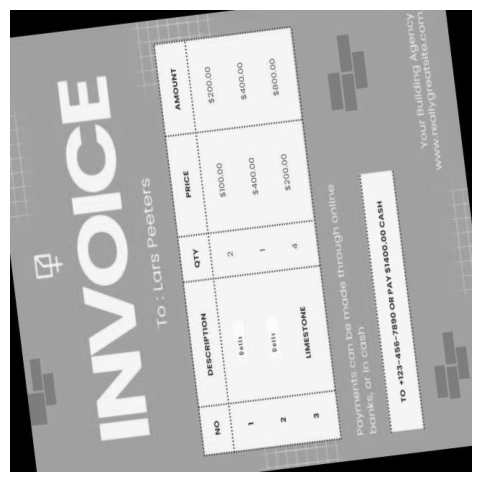

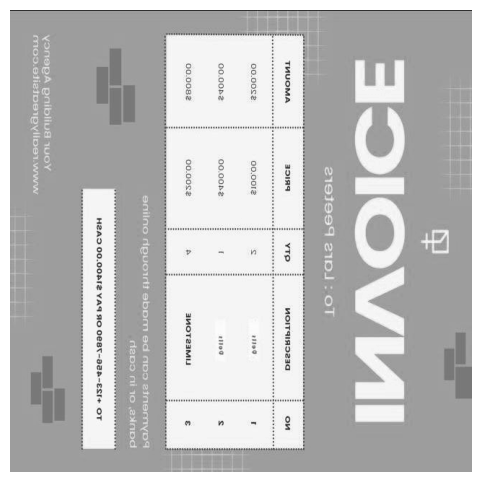

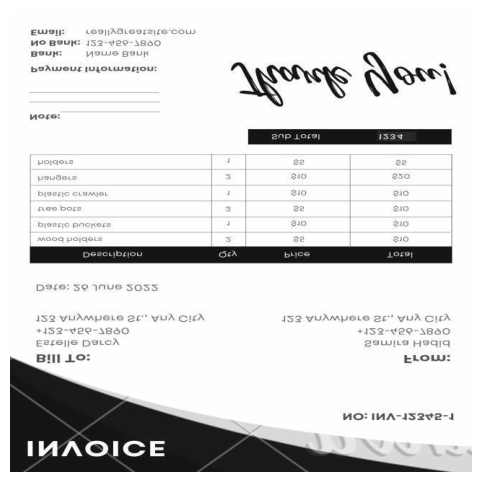

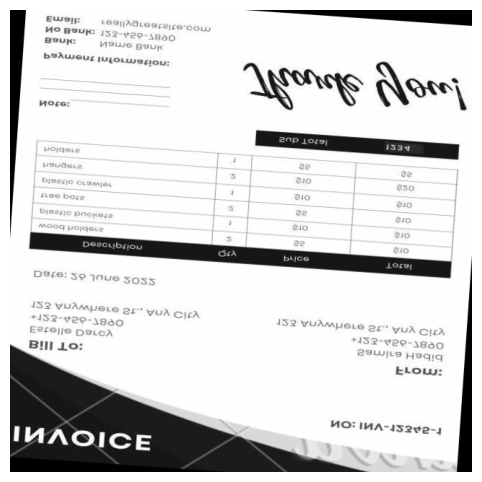

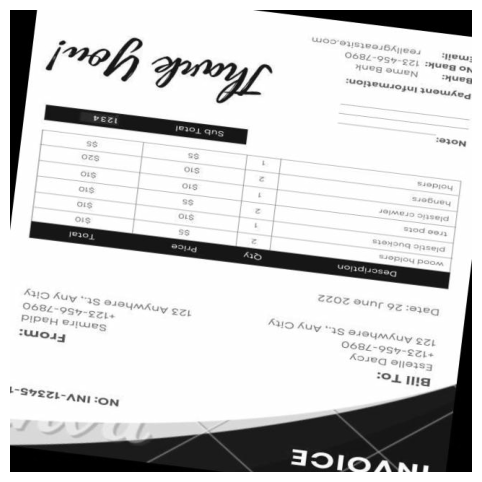

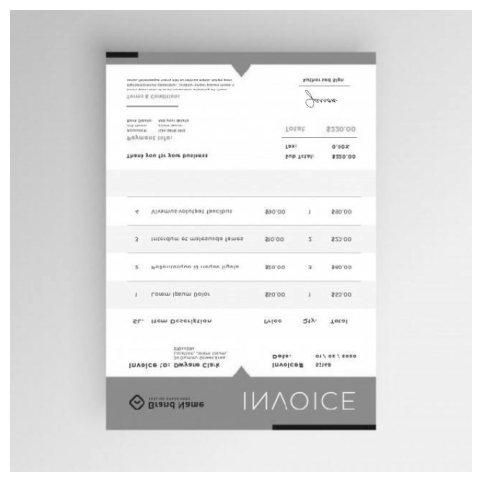

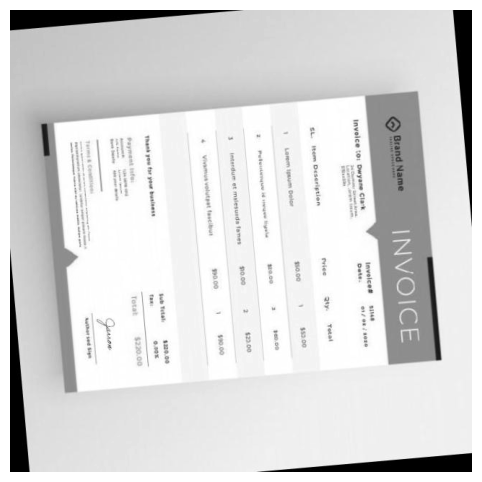

In [23]:
def convert_to_grayscale(image_files):
    """
    Convert a list of images to grayscale and display the results.
    """
    for image_file in image_files:
        img = cv2.imread(image_file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Display the grayscale image
        plt.figure(figsize=(8, 6))
        plt.imshow(gray_img, cmap="gray")
        plt.axis("off")
        # plt.title(f"Grayscale: {Path(image_file).name}")
        plt.show()

# Example Usage
convert_to_grayscale(image_files[1:20:3])


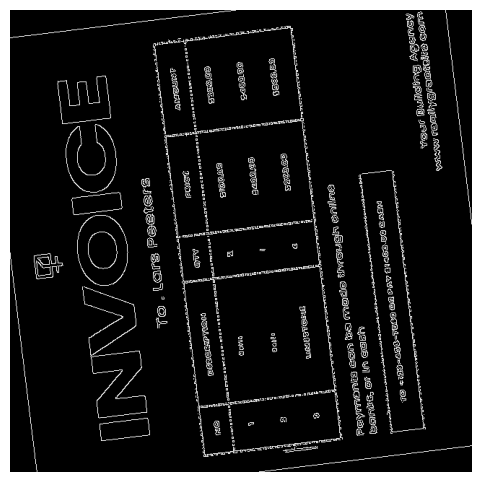

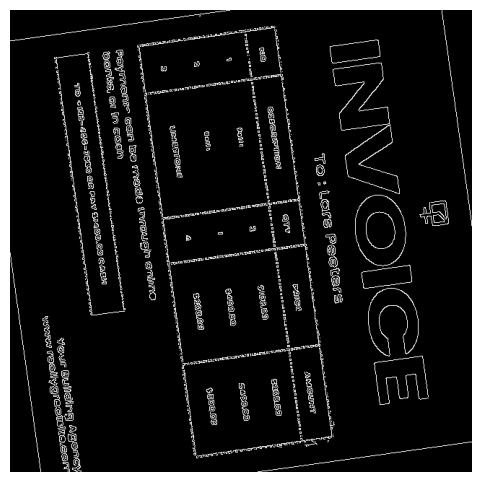

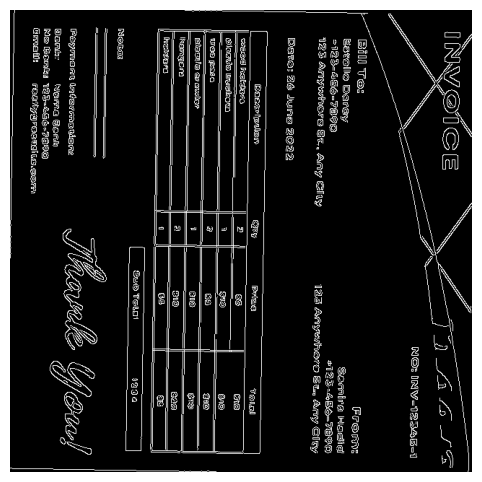

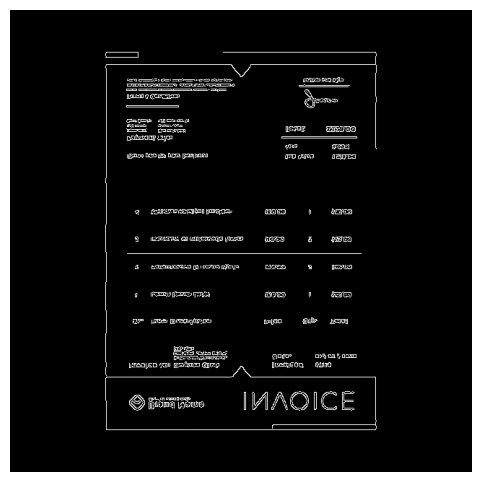

In [25]:
def apply_edge_detection(image_files):
    """
    Apply Canny edge detection to a list of images and display the results.
    """
    for image_file in image_files:
        img = cv2.imread(image_file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_img, 100, 200)

        # Display the edge-detected image
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap="gray")
        plt.axis("off")
        # plt.title(f"Edge Detection: {Path(image_file).name}")
        plt.show()

# Example Usage
apply_edge_detection(image_files[1:20:5])


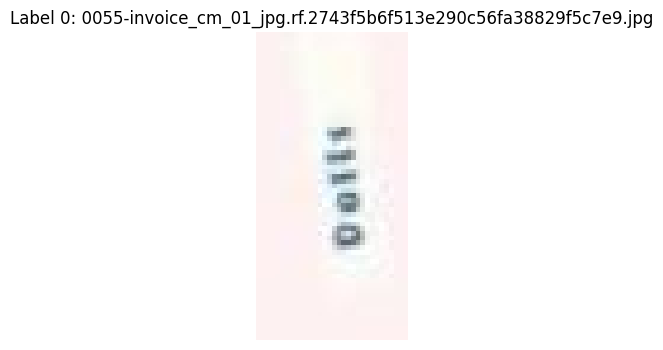

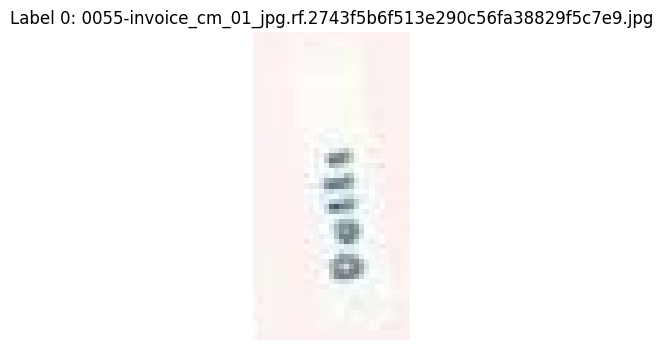

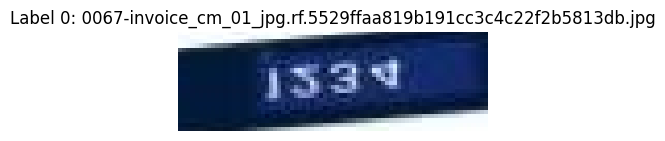

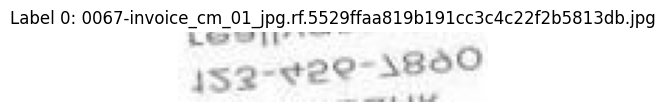

In [28]:
def highlight_labels(image_files, label_dir):
    """
    Highlight labeled regions based on YOLO labels and display the cropped regions.
    """
    for image_file in image_files:
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        label_file = Path(label_dir) / (Path(image_file).stem + ".txt")
        if label_file.exists():
            with open(label_file, "r") as file:
                for line in file.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    x1, y1 = int((x_center - width / 2) * w), int((y_center - height / 2) * h)
                    x2, y2 = int((x_center + width / 2) * w), int((y_center + height / 2) * h)

                    # Highlight the labeled region
                    cropped = img[y1:y2, x1:x2]
                    plt.figure(figsize=(4, 4))
                    plt.imshow(cropped)
                    plt.axis("off")
                    # plt.title(f"Label {int(class_id)}: {Path(image_file).name}")
                    plt.show()

# Example Usage
highlight_labels(image_files[1:15:7], label_dir)


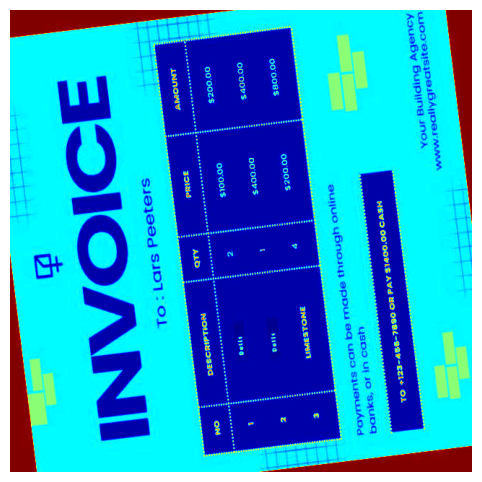

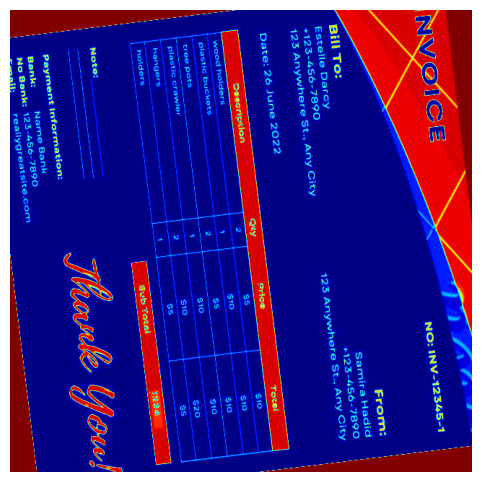

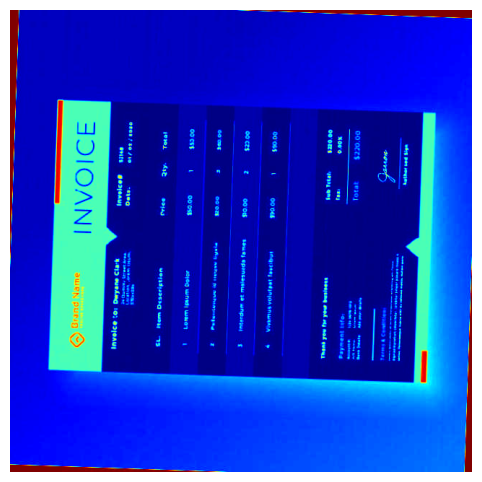

In [31]:
def apply_heatmap(image_files):
    """
    Apply a heatmap overlay to images for better visualization of intensity variations.
    """
    for image_file in image_files:
        img = cv2.imread(image_file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        heatmap = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

        # Display the heatmap overlay
        plt.figure(figsize=(8, 6))
        plt.imshow(heatmap)
        plt.axis("off")
        # plt.title(f"Heatmap Overlay: {Path(image_file).name}")
        plt.show()

# Example Usage
apply_heatmap(image_files[1:25:8])


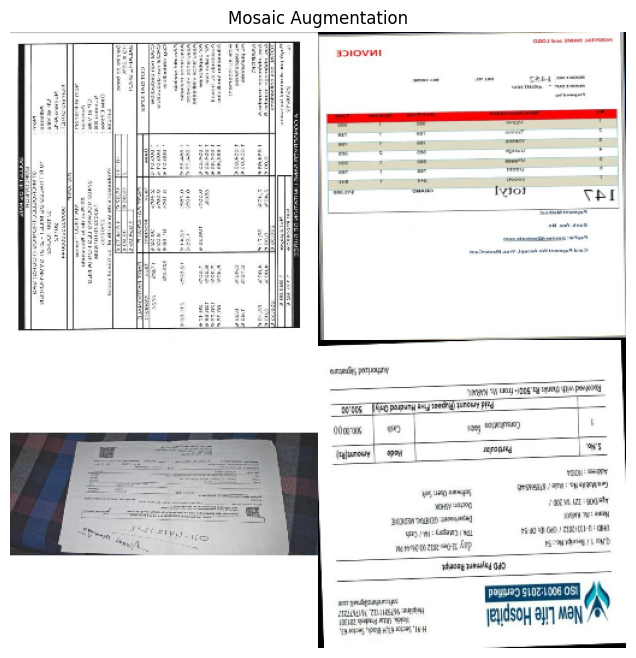

In [32]:
import random

def mosaic_augmentation(image_files):
    """
    Combine four random images into a single mosaic image.
    """
    selected_images = random.sample(image_files, 4)
    imgs = [cv2.imread(img) for img in selected_images]

    # Resize images to fit into quadrants
    resized_imgs = [cv2.resize(img, (256, 256)) for img in imgs]

    # Combine into a 2x2 grid
    top = cv2.hconcat(resized_imgs[:2])
    bottom = cv2.hconcat(resized_imgs[2:])
    mosaic = cv2.vconcat([top, bottom])

    # Display the mosaic image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Mosaic Augmentation")
    plt.show()

# Example Usage
mosaic_augmentation(image_files)
